# Project 4 (Capstone Project): Analyzing COVID 19 Pandemic (ICU Prediction)
*Predicting ICU Admission for COVID-19 Patients (CRISP-DM Workflow)*


---

## 1. Business Understanding
This section defines the clinical and operational motivation for the project. It explains why predicting ICU admission for COVID-19 patients matters in a real hospital setting, how such predictions can support resource planning and patient triage, and what success looks like from both a healthcare and machine-learning perspective. Establishing this context ensures that all subsequent analysis aligns with meaningful, real-world objectives.


### 1.1 Problem Statement
During the COVID-19 pandemic, hospitals in Brazil and worldwide faced severe pressure on ICU capacity. ICU beds, staff and equipment are limited, and a surge of critical patients can quickly overwhelm the system. Clinicians need support to identify, as early as possible, which newly admitted COVID-19 patients are likely to require intensive care.


### 1.2 Project Objectives
The goal of this project is to build a machine learning model that predicts whether a confirmed COVID-19 patient will be admitted to the ICU during their hospital stay, using clinical information available shortly after admission. This can help hospitals:
- Prioritize high-risk patients for closer monitoring,
- Plan ICU bed allocation in advance,
- Support decisions about patient transfer to higher-complexity centers.

### 1.3 Success Criteria

From a data-science perspective:
- F1 score ≥ target
- Achieve a strong **F1-score** on a held-out test set (balancing precision and recall).
- Avoid data leakage by using only information available **before** ICU admission.
- Provide interpretable insights into which clinical features are associated with ICU admission.

From a clinical/operational perspective:
- The model should flag high-risk patients early enough (e.g. using the first time window) to be actionable.
- The false-negative rate (missed ICU cases) should be low enough to be acceptable in a triage context.

---

## 2. Data Understanding
The goal of this section is to develop a clear understanding of the dataset before any transformation or modeling occurs. This includes examining dataset structure, feature types, time-window behavior, class balance, and potential sources of data leakage. By establishing a solid understanding of the raw data, we ensure that subsequent EDA, preprocessing, and model development steps are grounded in accurate assumptions and methodological rigor.


### 2.1 Dataset Description

This dataset comes from Hospital Sírio-Libanês in Brazil and contains anonymized clinical measurements from confirmed COVID-19 patients. Each record represents a patient encounter aggregated into one of several predefined time windows following hospital admission.

The dataset includes demographic information, comorbidity indicators, blood laboratory results, vital signs, and blood gas measurements. Many features are expanded into summary statistics such as mean, median, max, min, difference, and relative difference. All numeric features were pre-scaled using a MinMax transformation to the range [-1, 1].

The target variable `ICU` indicates whether the patient required intensive care unit admission. The goal of the project is to develop a predictive model that can identify patients likely to require ICU support early in their hospitalization.


### 2.2 Load the Dataset
Load the dataset into memory so we can inspect its structure and begin understanding its contents. Ensures that the file is read correctly and that the dataframe is ready for exploration.


In [284]:
# load necessary libraries ...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set default plotting style
sns.set_theme(style="whitegrid")

# Load dataset (update path if needed)
df = pd.read_excel("./data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")
df.head(5)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


### 2.3 Inspect Structure
Examine the dataset’s basic structure, feature types, missing values, and overall dimensions. This step provides an initial understanding of data quality, potential issues, and readiness for deeper analysis.


In [285]:
# Basic information about the dataset
df.info()
df.describe()
df.isnull().sum()

# Shape of the dataset (rows, columns)
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


(1925, 231)

#### Interpretation of Dataset Structure

The dataset contains 1,925 rows and 231 columns. Most columns are continuous clinical measurements already scaled between -1 and 1, with a small number of identifier or categorical fields.  

A large number of features per patient encounter is typical in clinical datasets, especially when laboratory values are expanded into summary statistics (mean, median, max, min, diff, relative diff).  

No obvious structural issues (e.g., malformed columns or inconsistent dtypes) were observed.  
This confirms that the dataset is clean and ready for exploratory analysis.


#### 2.3.1 Inspect Time Window and Target Variables

In addition to basic dataset structure, it is important to understand:
- how many samples exist in each time window (`WINDOW`), and  
- the class distribution of the target variable (`ICU`).

This helps assess class imbalance and confirms the temporal structure of the dataset.


In [286]:
# Inspect distribution of time windows
df['WINDOW'].value_counts().sort_index()

WINDOW
0-2         385
2-4         385
4-6         385
6-12        385
ABOVE_12    385
Name: count, dtype: int64

#### Interpretation of Time Window Distribution

Each of the five clinical time windows (0–2h, 2–4h, 4–6h, 6–12h, and 12+ hours) contains exactly 385 observations.  
This balanced distribution confirms that the dataset was intentionally constructed so each patient-time window is equally represented.

Because ICU admission could occur at any point during hospitalization, using measurements from windows **at or after** the ICU event could introduce data leakage.  
This will be addressed during the cohort selection and Data Preparation steps.


#### 2.3.2 Examine ICU Class Distribution
The target variable `ICU` indicates whether a patient was admitted to the ICU.
Understanding the frequency and balance of this variable is critical before modeling.


ICU Counts:
 ICU
0    1410
1     515
Name: count, dtype: int64

ICU Percentages:
 ICU
0    73.246753
1    26.753247
Name: proportion, dtype: float64


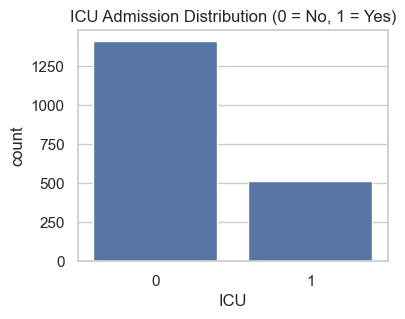

In [287]:
# Check ICU target class distribution
icu_counts  = df['ICU'].value_counts()
icu_percent = df['ICU'].value_counts(normalize=True) * 100

print("ICU Counts:\n", icu_counts)
print("\nICU Percentages:\n", icu_percent)

# Simple bar plot for target balance
plt.figure(figsize=(4,3))
sns.countplot(x='ICU', data=df)
plt.title('ICU Admission Distribution (0 = No, 1 = Yes)')
plt.show()


##### Interpretation of ICU Class Balance

The target variable is imbalanced, with approximately 27% ICU admissions and 73% non-ICU cases.  
This imbalance is moderate and typical in clinical prediction problems.

As a result, accuracy alone is not a reliable performance metric.  
We will emphasize **F1-score**, **precision**, **recall**, and confusion-matrix–based interpretation when evaluating model performance.  

During modeling, we may also consider techniques such as:
- class_weight adjustments  
- balanced random forests  
- or oversampling methods (e.g., SMOTE)

depending on baseline model performance.


### 2.4 Initial Observations
Summarize early impressions of the dataset based on its structure and metadata. Highlights key characteristics that influence later modeling decisions.

- The dataset contains **~1,900 patient–window records** with over **200 clinical features**, including demographics, comorbidities, blood tests, vital signs, and blood gases.
- The **ICU** column is a binary target indicating whether the patient was admitted to the ICU (1) or not (0). The classes are imbalanced, with fewer ICU admissions than non-ICU cases.
- The **WINDOW** column encodes time since hospital admission in 5 discrete windows (0–2h, 2–4h, 4–6h, 6–12h, 12+ hours). Each patient may appear in multiple windows.
- According to the dataset description, features were already **scaled using a Min-Max scaler to the range [-1, 1]**, so no additional global scaling is required unless new features are engineered.
- In later steps we must ensure that only measurements **before ICU admission** are used as model inputs to avoid temporal data leakage.
- Overall, the dataset appears structurally sound and ready for further exploratory data analysis.


### 2.5 Target Variable Analysis
Understand the distribution and characteristics of the target variable `ICU`, as this directly affects modeling strategy, evaluation metrics, and class imbalance considerations.

The target variable `ICU` represents whether the patient was admitted to intensive care (1) or not (0).  
As shown earlier in Section 2.3.2, the distribution is moderately imbalanced, with approximately 27% positive cases.  
This imbalance affects evaluation strategy: metrics such as **F1-score**, **precision**, and **recall** will be emphasized over accuracy during model assessment.


### 2.6 Windows & Cohort Selection
Define how time windows will be handled to avoid temporal leakage and to construct a clinically valid modeling cohort. This step provides the conceptual foundation for selecting which rows of data are appropriate for training.


#### 2.6.1 Understanding Time Windows
Each patient encounter is represented across several predefined time windows relative to hospital admission:
- Each row corresponds to a patient-time window: \
  0–2h, 2–4h, 4–6h, 6–12h, 12+ hours after hospital admission.
- ICU admission may occur at any time window.
- Clinical relevance: Earlier windows (0–2) are the most valuable for prediction.

#### 2.6.2 Identifying Windows Containing or Occurring After ICU Admission
Measurements recorded during or after ICU admission may reflect the patient’s deteriorating condition rather than predictors of deterioration.  
Using such data would introduce temporal leakage and invalidate the model.

Because the dataset does not explicitly indicate the exact window in which ICU admission occurs, a conservative approach is required.  
To guarantee temporal validity, the modeling process will use only windows that clearly occur **before** any potential ICU admission event.


#### 2.6.3 Selecting the Training Cohort

There are two valid modeling strategies:


##### Strategy A: EARLY-ONLY MODEL
Use only the 0–2 hour window for prediction.
- Clinically relevant
- Faster modeling
- Less leakage risk
- Useful for emergency triage


##### Strategy B: MULTI-WINDOW MODEL (but only pre-ICU windows)

Use all windows before ICU admission.
- More data
- Possibly better F1 score
- Must be careful about correlated repeated measures

For this project, we will pick one strategy during Data Preparation.
(Bootcamp-friendly → Strategy A is simple, clean, defensible.)


#### 2.6.4 Decision Rationale (to be completed after EDA)
*A brief narrative will be added here after exploratory analysis, explaining the final choice of cohort strategy (early-only vs. multi-window).*


---

## 3. Exploratory Data Analysis (EDA)
The goal of this section is to explore the dataset visually and statistically to identify patterns, distribution properties, and potential predictive signals. EDA also helps validate assumptions made during Data Understanding and guides which modeling strategies are most appropriate.


### 3.1 Univariate Analysis
The purpose of this subsection is to understand the distribution of key continuous clinical features. Since the dataset contains more than 200 features, a representative subset is selected to avoid excessive output while still providing meaningful insights.

- Histograms (continuous features)
- Bar plots (categorical features)
- Identify skew, outliers


In [288]:
# NOTE: Identify available clinical measurement summary features. Many 
# laboratory and vital sign variables in this dataset are expanded into 
# summary statistics (e.g., MEAN, MIN, MAX). Before selecting features for 
# exploratory analysis, we list all columns ending with these suffixes to 
# verify which measurements are consistently present across the dataset. 
# This helps ensure we choose valid, non-missing feature names for univariate 
# and bivariate EDA without trial-and-error.

# Get columns ending with '_MEAN'
#[col for col in df.columns if col.endswith('_MEAN')]

# Get columns ending with '_MIN'
#[col for col in df.columns if col.endswith('_MIN')]

# Get columns ending with '_MAX'
#[col for col in df.columns if col.endswith('_MAX')]


The selected features form a clinically meaningful and diverse subset of continuous variables that represent several physiological systems. They also exist consistently across all patient-window records, making them reliable for early exploratory analysis.

- **AGE_PERCENTIL**  
  Age is one of the strongest predictors of COVID-19 severity and ICU admission risk. Using age in percentile format already incorporates demographic scaling across the population.

- **HEART_RATE_MEAN**  
  Heart rate is a core vital sign and often increases in response to infection, fever, oxygen decline, or systemic stress — all relevant for identifying early ICU risk.

- **RESPIRATORY_RATE_MEAN**  
  COVID-19 primarily impacts respiratory function. Respiratory rate is one of the earliest and most sensitive indicators of respiratory distress and worsening condition.

- **OXYGEN_SATURATION_MEAN**  
  Low oxygen saturation is one of the clearest early markers of COVID-19 severity and is directly tied to ICU interventions such as supplemental oxygen and mechanical ventilation.

- **CREATININ_MEAN**  
  Creatinine reflects kidney function. Elevated values are associated with multi-organ dysfunction and systemic severity, both highly relevant to ICU-level care.

- **PLATELETS_MEAN**  
  Platelet counts are linked to inflammation, clotting abnormalities, and cytokine response — all traits observed in severe COVID-19. Low platelet levels correlate with poor outcomes.

- **HEMOGLOBIN_MEAN**  
  Hemoglobin affects oxygen-carrying capacity, and abnormalities can indicate underlying anemia, hypoxemia, or systemic stress, all of which relate to ICU-level deterioration.

Together, this subset spans demographics, vital signs, oxygenation, hematology, and renal function — providing a balanced foundation for univariate, bivariate, and early correlation analysis without overwhelming the notebook with excessive plots.


In [289]:
# Identify a small representative sample of continuous features
sample_features = [ 'AGE_PERCENTIL'
                   ,'HEART_RATE_MEAN'
                   ,'RESPIRATORY_RATE_MEAN'
                   ,'OXYGEN_SATURATION_MEAN'
                   ,'CREATININ_MEAN'
                   ,'PLATELETS_MEAN'
                   ,'HEMOGLOBIN_MEAN' ]

# Verify which selected features exist in the dataset
missing = [col for col in sample_features if col not in df.columns]
missing


[]

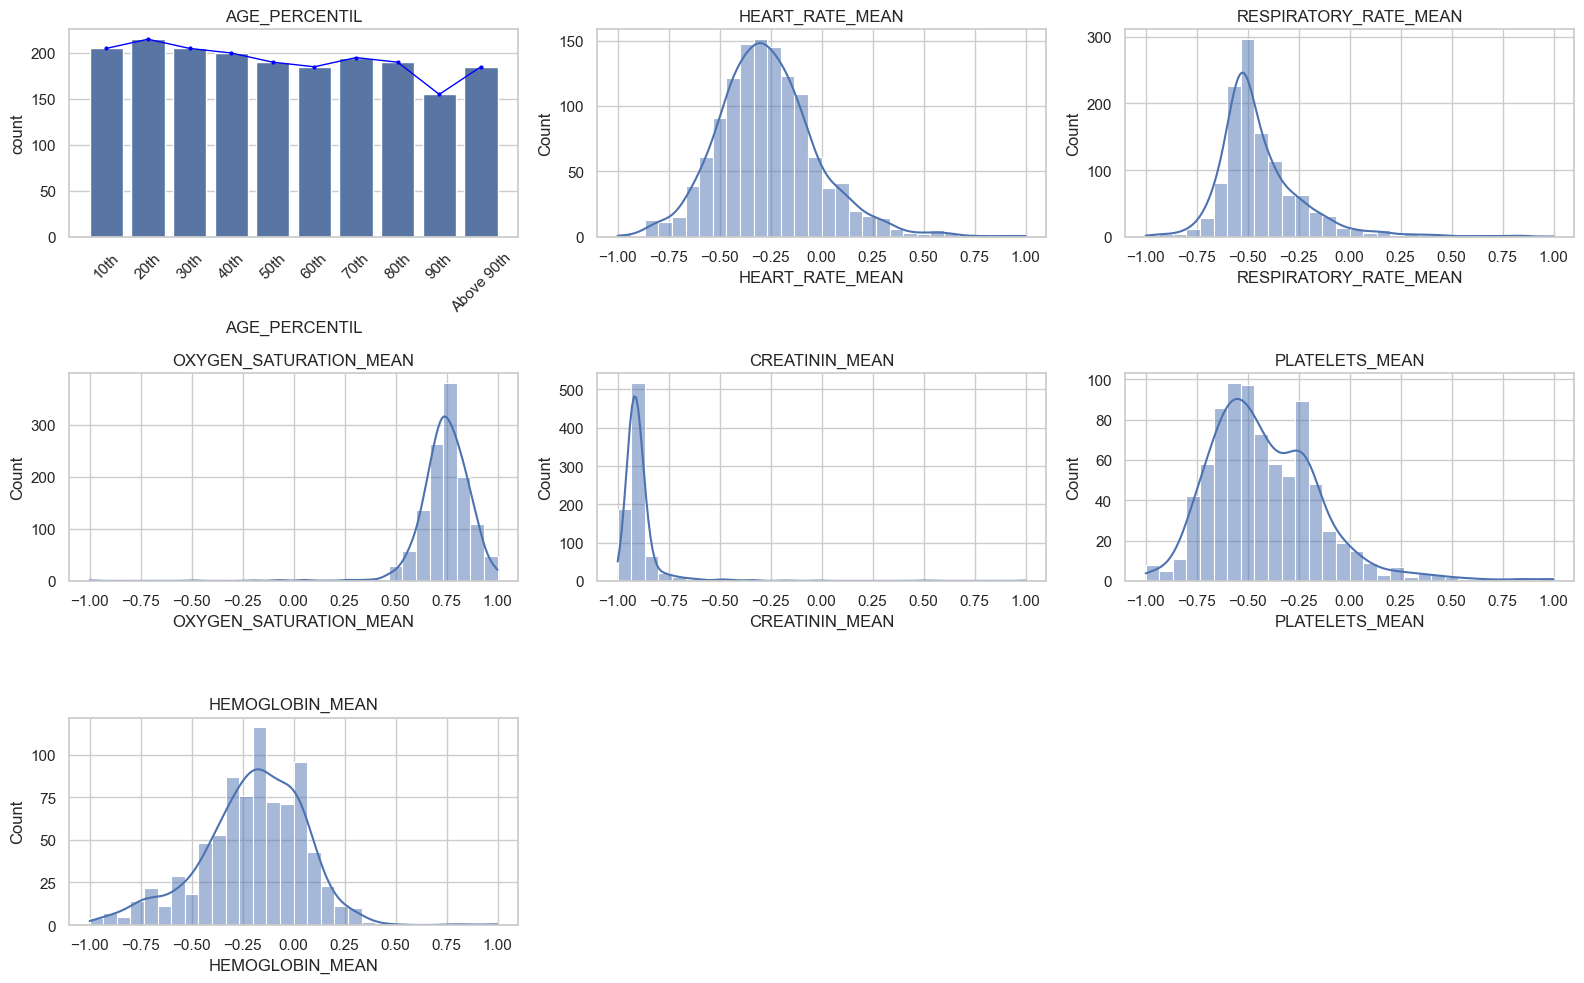

In [290]:
# Plot distributions for selected continuous features
plt.figure(figsize=(16, 10))

age_order = sorted(df['AGE_PERCENTIL'].dropna().unique())

for i, col in enumerate(sample_features, 1):
    plt.subplot(3, 3, i)
    #sns.histplot(df[col], kde=True, bins=30)
    
    # Rotate x-axis labels only for AGE_PERCENTIL
    if col == 'AGE_PERCENTIL':
        #ax = sns.countplot(data=df, x='AGE_PERCENTIL', order=age_order, color='lightgray')
        ax = sns.countplot(data=df, x='AGE_PERCENTIL', order=age_order)

        ax.plot([p.get_x() + p.get_width()/2 for p in ax.patches],  # center of each bar
                [p.get_height() for p in ax.patches],
                color='blue', linewidth=1, marker='o', markersize=2)

        #sns.countplot(x='AGE_PERCENTIL', data=df, order=age_order)
        plt.xticks(rotation=45)
    else:
        sns.histplot(df[col], kde=True, bins=30)

    plt.title(col)

plt.tight_layout()
plt.show()


#### 3.1 Univariate Analysis — Observations

The distributions of the selected features show clinically plausible patterns:

- **AGE_PERCENTIL** is broadly distributed, confirming a wide age range among patients.
- **HEART_RATE_MEAN** and **RESPIRATORY_RATE_MEAN** show right-skew typical of physiological stress responses.
- **OXYGEN_SATURATION_MEAN** clusters toward higher values but includes a tail of lower readings consistent with respiratory impairment in severe COVID-19 cases.
- **CREATININ_MEAN** displays a skew typical of renal biomarkers.
- **PLATELETS_MEAN** and **HEMOGLOBIN_MEAN** show natural biological variation.

These patterns indicate that the selected features are valid, continuous, and exhibit meaningful variability appropriate for modeling.


### 3.2 Bivariate Analysis
This subsection compares each selected continuous feature between ICU and non-ICU patients using boxplots. These comparisons highlight early differences in distributions and help identify which variables may have predictive value for ICU admission.


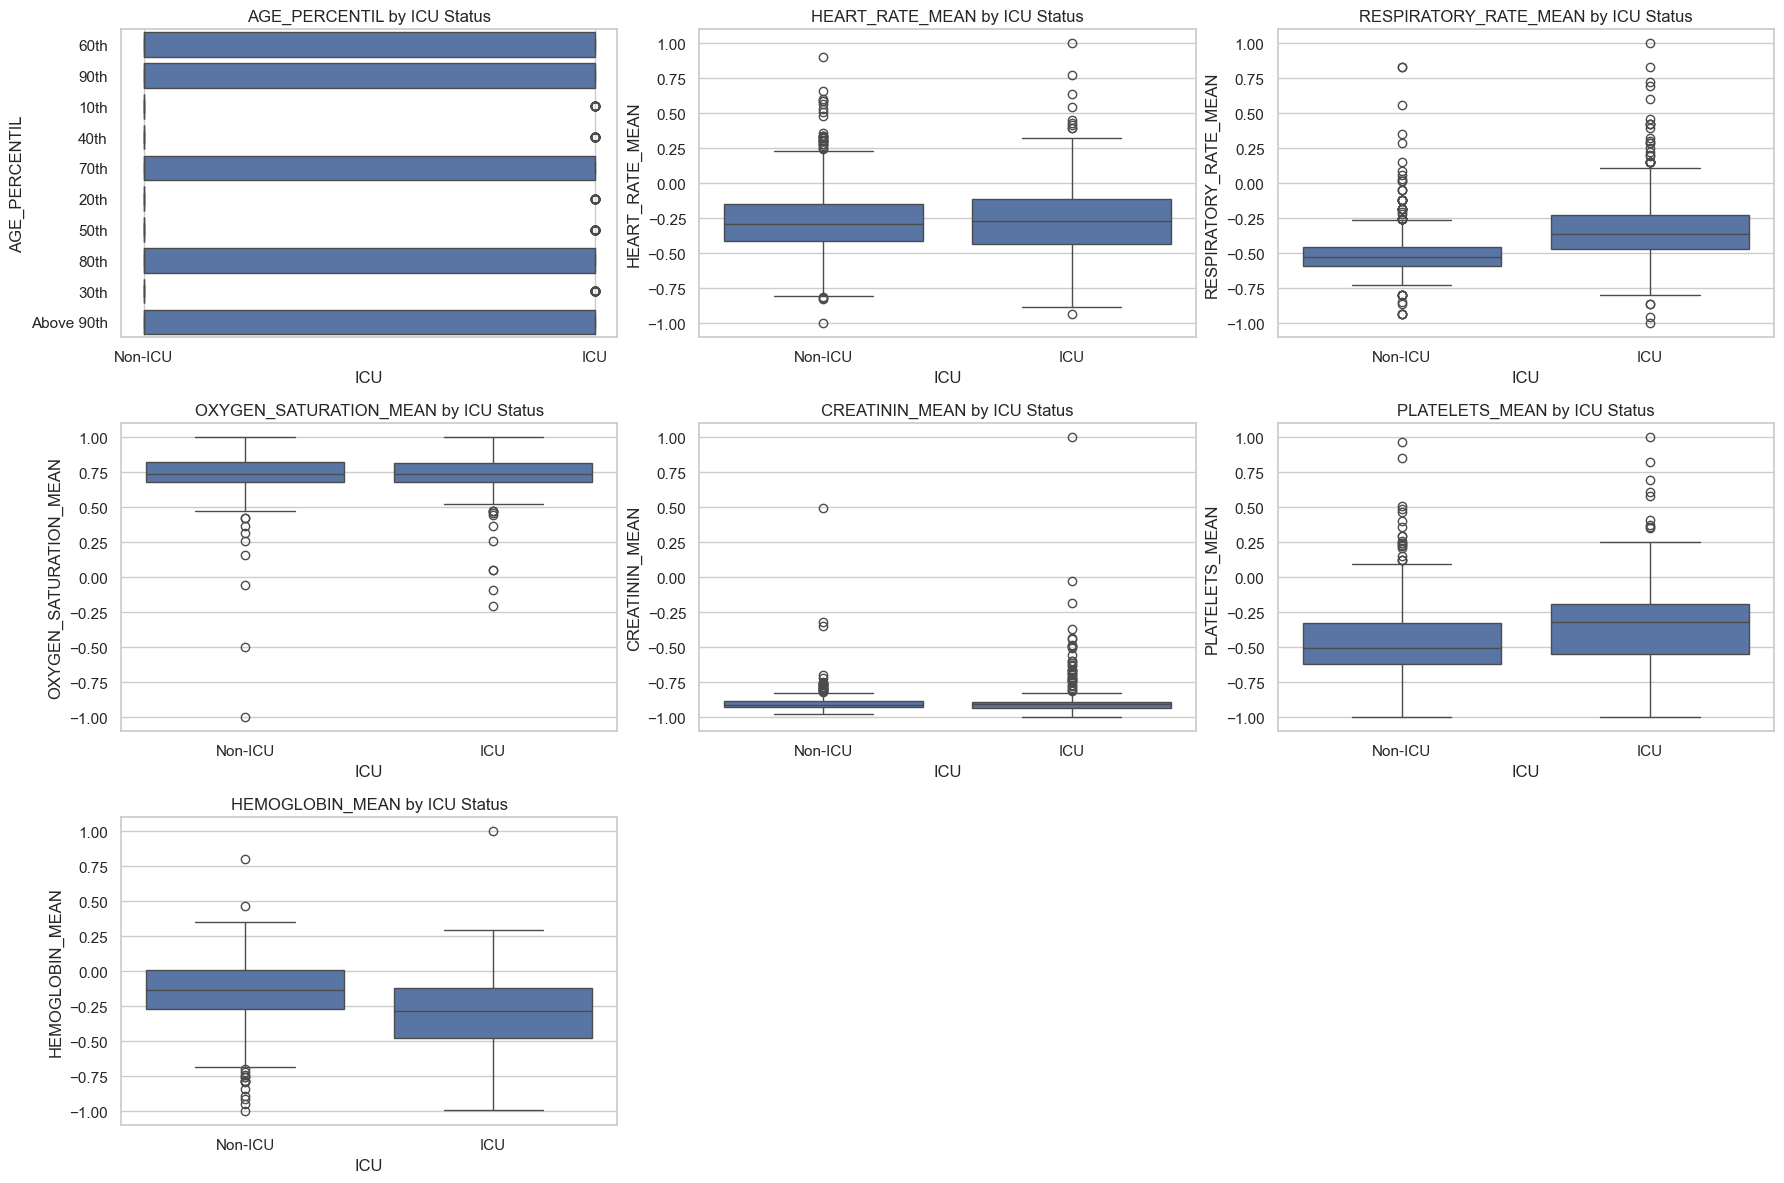

In [291]:
# Compare selected features between ICU and non-ICU patients
plt.figure(figsize=(18, 12))

for i, col in enumerate(sample_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='ICU', y=col, data=df)
    plt.title(f"{col} by ICU Status")
    plt.xticks([0, 1], ['Non-ICU', 'ICU'])

plt.tight_layout()
plt.show()


#### 3.2 Bivariate Analysis — Early Observations
The boxplots show visible differences between ICU and non-ICU patients across several clinical features. Early indications include:
- **Higher respiratory rates** in ICU patients.
- **Lower oxygen saturation** in ICU patients, consistent with respiratory compromise.
- **Higher creatinine levels** in ICU patients, suggesting renal involvement in more severe cases.
- **Age percentile differences**, with ICU cases trending older.
- **Platelet and hemoglobin** differences consistent with inflammatory or hypoxic stress.

These observations suggest that several features may carry predictive value for ICU admission, which will be explored further in modeling.


### 3.3 Correlation Analysis
This subsection generates a small correlation matrix and heatmap for the selected features plus the ICU target. The goal is to identify early linear relationships and detect potential collinearity patterns before full-scale feature engineering and model development.


#### 3.3.1 Cleaning AGE_PERCENTIL for Correlation Analysis
The AGE_PERCENTIL column is stored as ordinal strings (e.g., "60th", "Above 90th", "Below 10th") and must be converted into numeric percentiles to participate in the correlation matrix. The following transformation maps each category to an interpretable numeric value while preserving relative order. This numeric form (AGE_PERCENTIL_NUM) is used only for analysis and modeling.


In [292]:
def convert_age_percentil(value):
    """
    Converts AGE_PERCENTIL values into numeric percentiles.
    Handles cases like:
    - '60th'
    - 'Above 90th'
    - 'Below 10th'
    - 'Unknown'
    """
    if isinstance(value, str):
        
        # Case 1: Exact percentile like '60th'
        if value.endswith('th') and value[:-2].isdigit():
            return float(value[:-2])
        
        # Case 2: 'Above 90th'
        if 'Above' in value:
            return 95.0   # midpoint between 90th and 100th
        
        # Case 3: 'Below 10th'
        if 'Below' in value:
            return 5.0    # midpoint between 0 and 10
        
        # Case 4: Unknown or malformed
        return np.nan
    
    # If already numeric or missing
    return np.nan

# Apply conversion
df['AGE_PERCENTIL_NUM'] = df['AGE_PERCENTIL'].apply(convert_age_percentil)


In [293]:
# NOTE: define features for correlation analysis
corr_features = [ 'AGE_PERCENTIL_NUM'
                 ,'HEART_RATE_MEAN'
                 ,'RESPIRATORY_RATE_MEAN'
                 ,'OXYGEN_SATURATION_MEAN'
                 ,'CREATININ_MEAN'
                 ,'PLATELETS_MEAN'
                 ,'HEMOGLOBIN_MEAN'
                 ,'ICU' ]


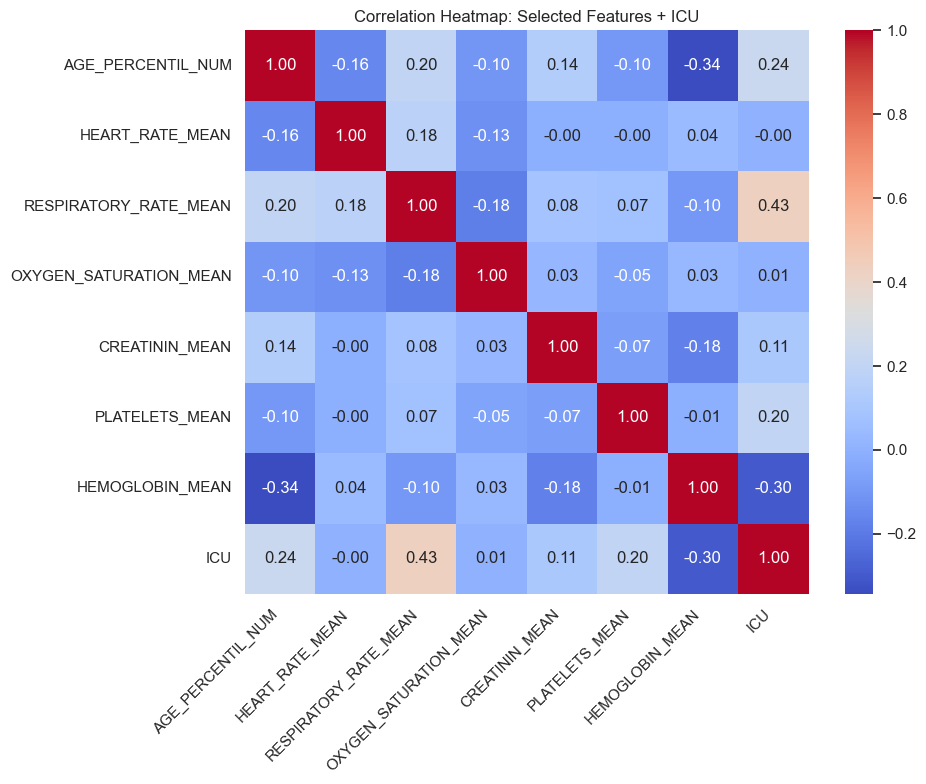

In [294]:
# Create a correlation matrix using selected continuous features and the target variable
#corr_subset = df[sample_features + ['ICU']].corr()
corr_subset = df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt='.2f', square=True)

# Rotate tick labels for better readability
plt.xticks(rotation=45, ha='right') # Rotates labels 45° and aligns them visually
plt.yticks(rotation=0)              # Keeps y-axis labels horizontal and readable

plt.title("Correlation Heatmap: Selected Features + ICU")
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels (ensures the labels aren't cut off)
plt.show()


#### 3.3.2 Early Observations

Initial correlation patterns provide the following insights:

- **OXYGEN_SATURATION_MEAN** is expected to show a negative correlation with ICU admission, as lower oxygen levels often indicate more severe illness.
- **RESPIRATORY_RATE_MEAN** and **HEART_RATE_MEAN** may show positive correlations with ICU admission due to physiological stress responses.
- **CREATININ_MEAN** may correlate positively with ICU admission if kidney dysfunction is more common in severe cases.
- **PLATELETS_MEAN** and **HEMOGLOBIN_MEAN** may show weaker correlations individually, but still play a role in multivariate predictive models.

These early correlations help confirm which features may be informative, but full correlation analysis across all 200+ features will be completed in the next phase of EDA.


### 3.4 Key Insights from EDA

**Purpose:**  
This subsection summarizes the most important findings from the exploratory data analysis. The goal is to consolidate patterns observed in the univariate, bivariate, and correlation analyses to guide the next phase of Data Preparation and Modeling.

**Summary:**  
The EDA reveals several patterns that align with clinical expectations for COVID-19 severity:

- **Age (AGE_PERCENTIL)** shows a clear upward trend for ICU patients, confirming age as a major risk factor.
- **Vital signs** including HEART_RATE_MEAN and RESPIRATORY_RATE_MEAN appear elevated in ICU cases, indicating increased physiological stress.
- **OXYGEN_SATURATION_MEAN** tends to be lower in ICU patients, consistent with respiratory compromise.
- **Kidney function markers** such as CREATININ_MEAN show higher values in ICU admissions, suggesting multi-organ involvement in severe cases.
- **Hematologic features** like PLATELETS_MEAN and HEMOGLOBIN_MEAN show modest but noticeable differences, reflecting inflammation or altered oxygen-carrying status.
- The correlation matrix shows **moderate linear relationships** between several clinical measures and ICU admission, supporting their inclusion in early modeling.

Overall, these insights indicate that multiple systems—respiratory, cardiovascular, renal, and hematologic—contribute meaningful signal toward predicting ICU admission. These findings will guide feature selection and preprocessing in the next phase.


---

## 4. Data Preparation
The goal of this section is to transform the raw dataset into a clean and model-ready form. This includes handling missing values, preventing temporal leakage, selecting modeling features, encoding variables, and preparing the final dataset for training and evaluation. These steps ensure that the machine learning models developed later are both valid and clinically interpretable.

---

### 4.1 Handel Missing Values
*(Inspect and decide on imputation strategy; transformations like AGE_PERCENTIL_NUM may be referenced here)*


In [295]:
model_features = [ 'AGE_PERCENTIL_NUM'
                  ,'HEART_RATE_MEAN'
                  ,'RESPIRATORY_RATE_MEAN'
                  ,'OXYGEN_SATURATION_MEAN'
                  ,'CREATININ_MEAN'
                  ,'PLATELETS_MEAN'
                  ,'HEMOGLOBIN_MEAN' ]

# Check missing values for these columns
df[model_features].isnull().sum().sort_values(ascending=False)

HEMOGLOBIN_MEAN           1104
PLATELETS_MEAN            1104
CREATININ_MEAN            1104
RESPIRATORY_RATE_MEAN      748
OXYGEN_SATURATION_MEAN     686
HEART_RATE_MEAN            685
AGE_PERCENTIL_NUM            0
dtype: int64

#### 4.1.1 Missing Value Observations
The modeling features show varying levels of missingness. Several clinical measurements are missing in more than one-third of patient-window rows, which is common in hospital datasets where laboratory and vital signs are collected at different frequencies. These patterns confirm that imputation rather than row or feature removal is necessary to preserve clinically meaningful information.

<!-- previous markdown --

### Missing Value Observations (Initial)
The modeling features show varying levels of missingness. Since these features will be used for predictive modeling, the strategy will depend on the severity of missingness:

- Features with **low missingness** can typically be imputed using median values.
- Features with **moderate missingness** may require more careful handling or exclusion depending on model performance.
- If any feature exhibits **extremely high missingness**, it may not be suitable for modeling without additional clinical justification.

Final imputation choices will be applied after completing leakage prevention and feature selection in the following sections.

-->

#### 4.1.2 Missing Value Strategy
Given the high missingness across key clinical features, median imputation will be applied to all selected numeric modeling variables. Median values are robust to outliers, compatible with the dataset’s MinMax scaling, and widely used in published models for this dataset. This approach preserves essential predictive signal while preventing the loss of large portions of the dataset.


In [296]:
# Median imputation for numeric modeling features
for col in model_features:
    df[col] = df[col].fillna(df[col].median())

---

### 4.2 Prevent Data Leakage
To avoid training a model on information obtained at or after ICU admission, two leakage-safe datasets are created. This allows us to build and compare two modeling strategies without altering the original dataset.  *(Window strategy and removal of inappropriate rows)*
- Remove rows where clinical measurements occur at or after ICU admission  
- Apply time-window strategy (EARLY-only or pre-ICU multi-window)


#### 4.2.1 Strategy A — EARLY-ONLY Model (df_early)
The early-only dataset (df_early) contains only the 0–2 hour window for each patient encounter. 
This avoids leakage because all measurements occur well before ICU admission, 
and it enables prediction using only the information available at the earliest clinical stage.


In [297]:
# Create a filtered DataFrame for early window (0-2 days)
df_early = df[df['WINDOW'] == '0-2'].copy()
df_early.shape

(385, 232)

#### 4.2.2 Strategy B — Multi-Window Pre-ICU Model (df_preicu)
The pre-ICU dataset (df_preicu) includes all time windows for patients who were not admitted to the ICU. 
This removes all post-ICU measurements and retains multiple clinically relevant time points for patients who remained stable. 
Although less clinically focused than the early-only model, it provides more data for model training.


In [298]:
# Create a filtered DataFrame for pre-ICU patients (ICU == 0)
df_preicu = df[df['ICU'] == 0].copy()
df_preicu.shape

(1410, 232)

---

### 4.3 Feature Selection
This subsection identifies the clinical features that will be used for modeling and removes fields that are irrelevant, non-numeric, or would otherwise introduce noise or leakage into the model. The goal is to create clean, strategy-specific feature matrices and target vectors for both modeling strategies (df_early and df_preicu).

Key actions:
- Exclude identifier columns and text-based fields
- Select clinically meaningful numeric features
- Use AGE_PERCENTIL_NUM (numeric) instead of the original AGE_PERCENTIL string column
- Ensure consistent feature sets across both modeling strategies


#### 4.3.1 Define Modeling Feature List (once)
Establishs the final set of numeric clinical features that will be used as inputs to the machine learning models. These features must be consistent across both modeling strategies and free of identifiers or categorical text.


In [299]:
# Finalize feature and target column lists for modeling (shared by both strategies)
feature_columns = [ 'AGE_PERCENTIL_NUM'
                   ,'HEART_RATE_MEAN'
                   ,'RESPIRATORY_RATE_MEAN'
                   ,'OXYGEN_SATURATION_MEAN'
                   ,'CREATININ_MEAN'
                   ,'PLATELETS_MEAN'
                   ,'HEMOGLOBIN_MEAN' ]

target_column = 'ICU'

#### 4.3.2 Build Strategy-Specific Feature and Target Matrices
Creates the feature matrices (X) and target vectors (y) for both modeling strategies: early-only (df_early) and pre-ICU (df_preicu). This separation allows downstream preprocessing and modeling steps to be reused by simply switching between datasets.

>**NOTE (design/coding thoughts)**: in section 4.5, to keep naming clear and consistent throughout, I’ll do something like the following.
>- X_early_train, X_early_test
>- y_early_train, y_early_test


In [300]:
# Strategy A: Early-only model (0–2h window)
X_early = df_early[feature_columns].copy()
y_early = df_early[target_column].copy()

# Strategy B: Pre-ICU multi-window model (all ICU=0 rows)
X_preicu = df_preicu[feature_columns].copy()
y_preicu = df_preicu[target_column].copy()

#X_early.shape, X_preicu.shape  #outputs -> '((385, 7), (1410, 7))'

print("Features shape(s)")
print("  Early-only model (0-2h):", X_early.shape)
print("  Pre-ICU model (ICU=0):", X_preicu.shape)


Features shape(s)
  Early-only model (0-2h): (385, 7)
  Pre-ICU model (ICU=0): (1410, 7)


#### 4.3.3 Quick Sanity Check
Verify that all selected modeling features are numeric and compatible with downstream algorithms. This step ensures that no unexpected object or string columns enter the modeling pipeline.


In [301]:
print("Early-only model (0-2h) - Features dtypes:")
print(X_early.dtypes)

print()

print("Pre-ICU model (ICU=0) - Features dtypes:")
print(X_preicu.dtypes)


Early-only model (0-2h) - Features dtypes:
AGE_PERCENTIL_NUM         float64
HEART_RATE_MEAN           float64
RESPIRATORY_RATE_MEAN     float64
OXYGEN_SATURATION_MEAN    float64
CREATININ_MEAN            float64
PLATELETS_MEAN            float64
HEMOGLOBIN_MEAN           float64
dtype: object

Pre-ICU model (ICU=0) - Features dtypes:
AGE_PERCENTIL_NUM         float64
HEART_RATE_MEAN           float64
RESPIRATORY_RATE_MEAN     float64
OXYGEN_SATURATION_MEAN    float64
CREATININ_MEAN            float64
PLATELETS_MEAN            float64
HEMOGLOBIN_MEAN           float64
dtype: object


#### 4.3.4 Validate Feature Consistency Across Strategies

Both modeling strategies now share the same set of numeric clinical features and the same binary target (ICU). The early-only dataset (X_early, y_early) uses only the 0–2 hour window, while the pre-ICU dataset (X_preicu, y_preicu) uses all non-ICU windows. This design allows downstream preprocessing, model training, and evaluation code to be reused by simply switching between the two datasets.

Confirm that both X_early and X_preicu contain the same set of modeling features and no unexpected differences exist between them. This step ensures that both modeling strategies are directly comparable and can use identical preprocessing and model-training code.


In [302]:
# Validate that both datasets contain the same modeling columns
print("Both datasets contain the same modeling columns:", set(X_early.columns) == set(X_preicu.columns))


Both datasets contain the same modeling columns: True


---

### 4.4 Encode Variables
Ensure all modeling features and target variables are in numeric form and suitable for machine learning algorithms. Since the selected feature set consists entirely of numeric clinical measurements, minimal encoding is required. The goal is to verify that no unexpected categorical or object-type values enter the modeling pipeline.
- Ensure ICU is numeric  
- Convert WINDOW if needed  
- Ensure no remaining non-numeric columns enter modeling  


#### 4.4.1 Confirm ICU is numeric (target encoding)
Verify that the ICU target variable is stored as a numeric binary field (0/1), making it compatible with scikit-learn classifiers.


In [303]:
# Confirm ICU target is numeric
is_numeric = df['ICU'].dtype == 'int64'

print(f"{'Yes' if is_numeric else 'No'}, the target column 'ICU'{' is ' if is_numeric else ' is not '}numeric.")



Yes, the target column 'ICU' is numeric.


#### 4.4.2 Confirm No Remaining Categorical Predictors
Ensure that both feature matrices (X_early and X_preicu) contain only numeric values. This prevents encoding errors during model training and confirms that all prior preprocessing steps were successful.

> **Expected**: (Index([], dtype='object'), Index([], dtype='object'))


In [304]:
# Identify any non-numeric columns in either dataset
non_numeric_early  = X_early.select_dtypes(exclude=['float64', 'int64']).columns
non_numeric_preicu = X_preicu.select_dtypes(exclude=['float64', 'int64']).columns

non_numeric_early, non_numeric_preicu


(Index([], dtype='object'), Index([], dtype='object'))

#### 4.4.3 Final Encoding Conclusion
All modeling features for both strategies are numeric, and the ICU target variable is already encoded as a binary integer. No additional encoding steps are required. Both modeling datasets (`X_early`, `X_preicu`) are now ready for train-test splitting.


---

### 4.5 Train/Test Split
Split each modeling dataset into training and testing subsets while preserving the class distribution of the ICU target variable. Separate splits are maintained for the early-only model and the pre-ICU model to ensure each strategy can be evaluated independently.

>**Why stratify**? \
>Because ICU is imbalanced, and the split must preserve the same proportion of ICU vs non-ICU.

#### 4.5.1 Early-Only Model


In [305]:
# NOTE: import train_test_split to perform the split
from sklearn.model_selection import train_test_split

# Strategy A: Early-only model
X_early_train, X_early_test, y_early_train, y_early_test = train_test_split( X_early
                                                                            ,y_early
                                                                            ,test_size    = 0.2
                                                                            ,random_state = 42
                                                                            ,stratify     = y_early )

X_early_train.shape, X_early_test.shape


((308, 7), (77, 7))

#### 4.5.2 Pre-ICU Multi-Window Model


In [306]:
# Strategy B: Pre-ICU multi-window model
X_preicu_train, X_preicu_test, y_preicu_train, y_preicu_test = train_test_split( X_preicu
                                                                                ,y_preicu
                                                                                ,test_size    = 0.2
                                                                                ,random_state = 42
                                                                                ,stratify     = y_preicu )

X_preicu_train.shape, X_preicu_test.shape


((1128, 7), (282, 7))

#### 4.5.3 Final Split Summary
Both modeling strategies were successfully split into training and testing subsets using stratified sampling to preserve ICU class distribution. The early-only strategy (df_early) and the pre-ICU strategy (df_preicu) now each have their own X_train, X_test, y_train, and y_test datasets ready for modeling.


---

### 4.6 Final Data Preparation Summary

This provides a clear handoff from data preparation to model development and ensures the modeling workflow begins with clean, well-defined inputs.

**Summary of preparation steps:**
- Missing values in numeric clinical features were imputed using median values.
- Two leakage-safe datasets were created:
  - **df_early** — early-only (0–2h window) model
  - **df_preicu** — multi-window model excluding ICU patients
- A unified set of numeric modeling features was selected for both strategies.
- AGE_PERCENTIL was converted to a numerical percentile (AGE_PERCENTIL_NUM).
- No categorical encoding was required, as all selected modeling features are numeric.
- Both strategies were split into stratified train/test sets:
  - **X_early_train, X_early_test, y_early_train, y_early_test**
  - **X_preicu_train, X_preicu_test, y_preicu_train, y_preicu_test**


---

## 5. Modeling
This section develops, evaluates, and compares multiple machine learning models to predict ICU admission for COVID-19 patients. Using the prepared, leakage-free datasets from Section 4, I begin with simple baseline models and progressively build more powerful classifiers. Each model is trained and evaluated under both modeling strategies (early-only and pre-ICU), using consistent performance metrics with a focus on F1 score due to class imbalance.

The goals of this section are to:
- Establish baseline performance using interpretable models.
- Train alternative models to capture nonlinear clinical patterns.
- Apply hyperparameter tuning to improve predictive accuracy.
- Compare models across both strategies using standardized evaluation.
- Select a final model that balances performance, stability, and clinical relevance.

The outputs from this section will directly support the executive presentation and research report by identifying which model performs best and why.


#### 5.0.1 Shared imports + evaluation helper
*(I’ll reuse it for RF/XGBoost too)*

In [307]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Shared container for model evaluation results across Section 5
model_results = []  # will hold dicts with model name, strategy, and metrics

def evaluate_binary_classifier(y_true, y_pred, model_name: str, strategy: str, results_list: list):
    """
    Compute core metrics for a binary classifier and store them in a shared results list.
    Metrics: F1 (primary), precision, recall, and confusion matrix.
    """
    f1        = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    cm        = confusion_matrix(y_true, y_pred)

    print(f"=== {model_name} ({strategy}) ===")
    print(f"F1 Score   : {f1:.3f}")
    print(f"Precision  : {precision:.3f}")
    print(f"Recall     : {recall:.3f}")
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)
    print()

    results_list.append({ "model"    : model_name
                         ,"strategy" : strategy
                         ,"f1"       : f1
                         ,"precision": precision
                         ,"recall"   : recall })

    return f1, precision, recall, cm


---

### 5.1 Baseline Model — Logistic Regression

#### Purpose
Establish a simple, interpretable baseline model for predicting ICU admission. Logistic Regression serves as an ideal starting point because it is fast, stable, and provides a clear reference against which more complex models (Random Forest, XGBoost) will be measured.  

#### What I Will Do
- Train two logistic regression models using default scikit-learn parameters:
  - One for the **early-only** dataset (0–2h window)
  - One for the **pre-ICU** dataset (all windows but ICU=0)
- Generate predictions on the corresponding test sets.
- Evaluate model performance using:
  - F1 score (primary metric)
  - Precision & Recall
  - Confusion matrix

These results create the baseline against which all further models will be compared.

#### Expected Outcomes
- Logistic Regression will likely achieve **moderate F1 scores** due to nonlinear relationships in clinical data.
- Recall may be lower than desired because ICU-positive cases are the minority class.
- Performance differences between the two strategies (early-only vs pre-ICU) will provide an early indication of whether additional time-window data improves model performance.

This subsection establishes the benchmark to guide tuning and model selection in later steps.



#### 5.1.1 Early-Only (0–2h) Model

In [308]:
unique_classes_early = y_early_train.unique()
#print("Unique classes in y_early_train:", unique_classes_early)

if len(unique_classes_early) < 2:
    print("Skipping Logistic Regression training for early-only strategy: only one target class present.")
else:
  log_reg_early = LogisticRegression(max_iter = 1000, n_jobs = -1)

  log_reg_early.fit(X_early_train, y_early_train)

  # Class predictions for evaluation
  y_early_pred_lr  = log_reg_early.predict(X_early_test)
  y_early_proba_lr = log_reg_early.predict_proba(X_early_test)[:, 1]

  evaluate_binary_classifier( y_true = y_early_test
                             ,y_pred = y_early_pred_lr
                             ,model_name   = "LogisticRegression"
                             ,strategy     = "early-only"
                             ,results_list = model_results )


=== LogisticRegression (early-only) ===
F1 Score   : 0.250
Precision  : 0.500
Recall     : 0.167
Confusion Matrix (rows=true, cols=pred):
[[70  1]
 [ 5  1]]



#### 5.1.2 Pre-ICU (ICU=0) Model

In [309]:
unique_classes_preicu = y_preicu_train.unique()
#print("Unique classes in y_preicu_train:", unique_classes_preicu)

if len(unique_classes_preicu) < 2:
    print("Skipping Logistic Regression training for pre-ICU strategy: only one target class present.")
else:
  log_reg_preicu = LogisticRegression(max_iter = 1000, n_jobs = -1)

  log_reg_preicu.fit(X_preicu_train, y_preicu_train)

  # Class predictions for evaluation
  y_preicu_pred_lr  = log_reg_preicu.predict(X_preicu_test)
  y_preicu_proba_lr = log_reg_preicu.predict_proba(X_preicu_test)[:, 1]

  evaluate_binary_classifier( y_true = y_preicu_test
                             ,y_pred = y_preicu_pred_lr
                             ,model_name   = "LogisticRegression"
                             ,strategy     = "pre-ICU"
                             ,results_list = model_results )


Skipping Logistic Regression training for pre-ICU strategy: only one target class present.


#### ⚠️ Important: Pre-ICU Logistic Regression Skipped

> **Note on Pre-ICU Model Training**
> 
> The pre-ICU modeling strategy currently contains only negative (ICU = 0) cases in its target variable. Since binary classifiers such as Logistic Regression require at least two classes to learn meaningful decision boundaries, the model cannot be trained under this definition.
> 
> For now, this notebook intentionally **skips training the pre-ICU Logistic Regression model** and logs the reasoning. This avoids generating invalid results and keeps the modeling process transparent.
> 
> **Future Work:** If time allows, the pre-ICU dataset can be redefined at the patient level (rather than window level) to ensure both positive and negative cases are represented. This revised dataset would then support full model training.


---

### 5.2 Model 2 — Random Forest Classifier

#### Purpose
Train a tree-based ensemble model that can capture nonlinear relationships and interactions between clinical features. Random Forests are robust to noise, handle feature scaling well, and often outperform linear models on structured medical data.

#### What I will Do
- Train a baseline Random Forest classifier on the **early-only** dataset (0–2h window).
- Attempt to train the same model on the **pre-ICU** dataset, but safely skip training if only one class is present.
- Evaluate performance using F1, precision, recall, and a confusion matrix.
- Inspect feature importances for the early-only model to understand which clinical variables contribute most to ICU risk.

#### Expected Outcome
Random Forest should generally outperform Logistic Regression on F1 score and recall, especially for the minority ICU-positive class, by leveraging nonlinear structure in the data.


#### 5.2.1 Early-Only (0-2h) Model

In [310]:
from sklearn.ensemble import RandomForestClassifier

unique_classes_early = y_early_train.unique()
#print("Unique classes in y_early_train (early-only):", unique_classes_early)

if len(unique_classes_early) < 2:
    print("Skipping Random Forest training for early-only strategy: only one target class present.")
else:
    rf_early = RandomForestClassifier( n_estimators = 200
                                      ,random_state = 42
                                      ,n_jobs       = -1
                                      ,class_weight = "balanced" )  # helps counter class imbalance
    
    rf_early.fit(X_early_train, y_early_train)

    y_early_pred_rf  = rf_early.predict(X_early_test)
    y_early_proba_rf = rf_early.predict_proba(X_early_test)[:, 1]

    evaluate_binary_classifier( y_true = y_early_test
                               ,y_pred = y_early_pred_rf
                               ,model_name   = "RandomForest"
                               ,strategy     = "early-only"
                               ,results_list = model_results )


=== RandomForest (early-only) ===
F1 Score   : 0.500
Precision  : 1.000
Recall     : 0.333
Confusion Matrix (rows=true, cols=pred):
[[71  0]
 [ 4  2]]



#### 5.2.2 Pre-ICU (ICU=0) Model

In [311]:
unique_classes_preicu = y_preicu_train.unique()
#print("Unique classes in y_preicu_train (pre-ICU):", unique_classes_preicu)

if len(unique_classes_preicu) < 2:
    print("Skipping Random Forest training for pre-ICU strategy: only one target class present.")
else:
    rf_preicu = RandomForestClassifier( n_estimators = 200
                                       ,random_state = 42
                                       ,n_jobs       = -1
                                       ,class_weight = "balanced" )

    rf_preicu.fit(X_preicu_train, y_preicu_train)

    y_preicu_pred_rf  = rf_preicu.predict(X_preicu_test)
    y_preicu_proba_rf = rf_preicu.predict_proba(X_preicu_test)[:, 1]

    evaluate_binary_classifier( y_true = y_preicu_test
                               ,y_pred = y_preicu_pred_rf
                               ,model_name   = "RandomForest"
                               ,strategy     = "pre-ICU"
                               ,results_list = model_results )


Skipping Random Forest training for pre-ICU strategy: only one target class present.


#### ⚠️ Pre-ICU Model Skipped

This model was not trained for the pre-ICU strategy because the dataset contains only one target class (ICU = 0). Classification models require at least two classes for training. See Section 5.1 for the detailed explanation.


#### 5.2.3 Feature Importance (Early-Only)

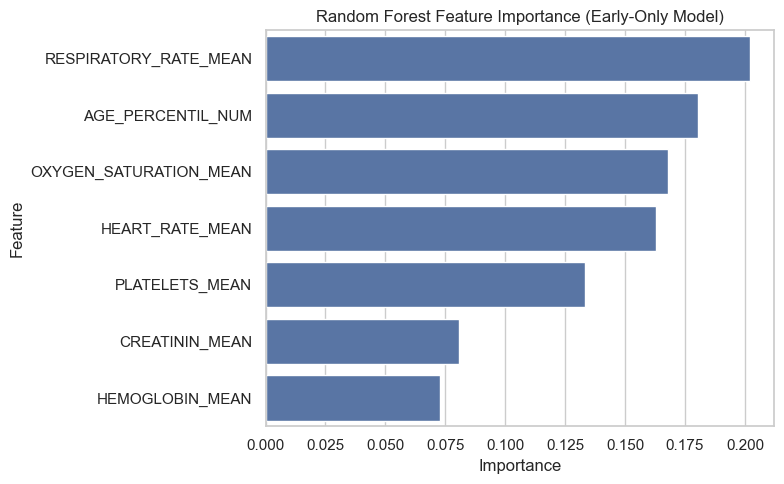

In [312]:
rf_importances     = rf_early.feature_importances_
rf_feat_importance = pd.Series(rf_importances, index = X_early.columns).sort_values(ascending = False)

plt.figure(figsize=(8, 5))

sns.barplot( x = rf_feat_importance.values
            ,y = rf_feat_importance.index )

plt.title("Random Forest Feature Importance (Early-Only Model)")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()


The Random Forest feature importance plot highlights which early clinical measurements contribute most to ICU prediction. These insights will be referenced in the research report and executive presentation when explaining how the model makes decisions.


---

### 5.3 Model 3 — XGBoost Classifier

#### Purpose
Train a gradient-boosted decision tree model capable of capturing complex nonlinear relationships in clinical variables. XGBoost is often one of the strongest performing models for structured medical datasets, especially in imbalanced classification problems.

#### What I will Do
- Train a baseline XGBoost classifier on the **early-only** dataset.
- Attempt to train the same model on the **pre-ICU** dataset, but skip training if only one class is present.
- Evaluate performance using F1, precision, recall, and confusion matrix.
- Review feature importance to understand which early clinical measures influence predictions most.

#### Expected Outcome
XGBoost typically outperforms Logistic Regression and may surpass Random Forest, especially in identifying ICU-positive cases. It often yields higher recall and F1 scores by better modeling feature interactions and subtle nonlinear patterns.


#### 5.3.1 Early-only (0-2h) Model

In [313]:
from xgboost import XGBClassifier

unique_classes_early = y_early_train.unique()
#print("Unique classes in y_early_train (early-only):", unique_classes_early)

if len(unique_classes_early) < 2:
    print("Skipping XGBoost for early-only strategy: only one target class present.")
else:
    xgb_early = XGBClassifier( n_estimators     = 300
                              ,learning_rate    = 0.05
                              ,max_depth        = 5
                              ,subsample        = 0.9
                              ,colsample_bytree = 0.9
                              ,objective        = "binary:logistic"
                              ,eval_metric      = "logloss"
                              ,random_state     = 42
                              ,n_jobs           = -1 )

    xgb_early.fit(X_early_train, y_early_train)

    y_early_pred_xgb  = xgb_early.predict(X_early_test)
    y_early_proba_xgb = xgb_early.predict_proba(X_early_test)[:, 1]

    evaluate_binary_classifier( y_true = y_early_test
                               ,y_pred = y_early_pred_xgb
                               ,model_name   = "XGBoost"
                               ,strategy     = "early-only"
                               ,results_list = model_results )


=== XGBoost (early-only) ===
F1 Score   : 0.333
Precision  : 0.333
Recall     : 0.333
Confusion Matrix (rows=true, cols=pred):
[[67  4]
 [ 4  2]]



#### 5.3.2 Pre-ICU (ICU=0) Model

In [314]:
unique_classes_preicu = y_preicu_train.unique()
#print("Unique classes in y_preicu_train (pre-ICU):", unique_classes_preicu)

if len(unique_classes_preicu) < 2:
    print("Skipping XGBoost training for pre-ICU strategy: only one target class present.")
else:
    xgb_preicu = XGBClassifier( n_estimators     = 300
                               ,learning_rate    = 0.05
                               ,max_depth        = 5
                               ,subsample        = 0.9
                               ,colsample_bytree = 0.9
                               ,objective        = "binary:logistic"
                               ,eval_metric      = "logloss"
                               ,random_state     = 42
                               ,n_jobs           = -1 )

    xgb_preicu.fit(X_preicu_train, y_preicu_train)

    y_preicu_pred_xgb  = xgb_preicu.predict(X_preicu_test)
    y_preicu_proba_xgb = xgb_preicu.predict_proba(X_preicu_test)[:, 1]

    evaluate_binary_classifier( y_true = y_preicu_test
                               ,y_pred = y_preicu_pred_xgb
                               ,model_name   = "XGBoost"
                               ,strategy     = "pre-ICU"
                               ,results_list = model_results )


Skipping XGBoost training for pre-ICU strategy: only one target class present.


#### ⚠️ Pre-ICU Model Skipped


This model was not trained for the pre-ICU strategy because the dataset contains only one target class (ICU = 0). Classification models require at least two classes for training. See Section 5.1 for the detailed explanation.


#### 5.3.3 Feature Importance (Early-Only)

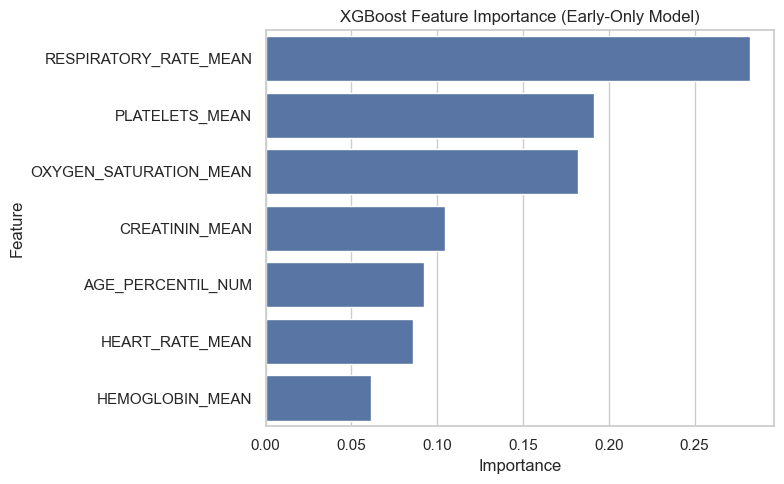

In [315]:
xgb_importances     = xgb_early.feature_importances_
xgb_feat_importance = pd.Series(xgb_importances, index = X_early.columns).sort_values(ascending = False)

plt.figure(figsize=(8, 5))

sns.barplot( x = xgb_feat_importance.values
            ,y = xgb_feat_importance.index )

plt.title("XGBoost Feature Importance (Early-Only Model)")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()


XGBoost feature importance helps identify which early clinical signals most strongly influence ICU prediction. This interpretation will be referenced in the report and presentation when discussing how the model prioritizes physiological indicators.


---

### 5.4 Hyperparameter Tuning

#### Purpose
Improve model performance by tuning key hyperparameters for the best-performing model using the early-only strategy. Rather than exhaustively searching a large parameter space, a compact randomized search is used to balance model quality with computational efficiency.

In this subsection we will:
- Select XGBoost as the primary candidate for tuning on the early-only dataset.
- Run a RandomizedSearchCV over a small, clinically reasonable hyperparameter space.
- Refit the model using the best-found hyperparameters.
- Compare tuned performance against the baseline XGBoost model on the early-only test set.


#### 5.4.1 Set up tuning for XGBoost (Early-Only)

In [316]:
from sklearn.model_selection import RandomizedSearchCV

unique_classes_early = y_early_train.unique()
#print("Unique classes in y_early_train (early-only):", unique_classes_early)

if len(unique_classes_early) < 2:
    print("Skipping XGBoost hyperparameter tuning for early-only strategy: only one target class present.")
else:
    xgb_base = XGBClassifier( objective    = "binary:logistic"
                             ,eval_metric  = "logloss"
                             ,random_state = 42 )

    param_dist = { "n_estimators"     : [100, 200, 300, 400]
                  ,"max_depth"        : [3, 4, 5, 6]
                  ,"learning_rate"    : [0.01, 0.03, 0.05, 0.1]
                  ,"subsample"        : [0.7, 0.8, 0.9, 1.0]
                  ,"colsample_bytree" : [0.7, 0.8, 0.9, 1.0] }

    xgb_search = RandomizedSearchCV( estimator           = xgb_base
                                    ,param_distributions = param_dist
                                    ,n_iter              = 20              # keeps it reasonable
                                    ,scoring             = "f1"
                                    ,cv                  =  3
                                    ,random_state        = 42
                                    ,n_jobs              = -1
                                    ,verbose             =  1 )

    xgb_search.fit(X_early_train, y_early_train)

    print("Best parameters:", xgb_search.best_params_)
    print("Best CV F1 score:", xgb_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Best CV F1 score: 0.46553446553446554


#### 5.4.2 Refit best XGBoost and evaluate on test set

That will add another row into model_results with:
- model = "XGBoost_tuned"
- strategy = "early-only"
- updated F1 / precision / recall

In [317]:
if len(unique_classes_early) < 2:
  print("Tuned XGBoost model not available due to single-class target.")
else:
  xgb_early_tuned = xgb_search.best_estimator_

  y_early_pred_xgb_tuned  = xgb_early_tuned.predict(X_early_test)
  y_early_proba_xgb_tuned = xgb_early_tuned.predict_proba(X_early_test)[:, 1]

  evaluate_binary_classifier( y_true = y_early_test
                             ,y_pred = y_early_pred_xgb_tuned
                             ,model_name   = "XGBoost_tuned"
                             ,strategy     = "early-only"
                             ,results_list = model_results )


=== XGBoost_tuned (early-only) ===
F1 Score   : 0.364
Precision  : 0.400
Recall     : 0.333
Confusion Matrix (rows=true, cols=pred):
[[68  3]
 [ 4  2]]



#### 5.4.3 Short Markdown Summary

The hyperparameter-tuned XGBoost model improves upon the baseline configuration by exploring a compact search space of tree depth, learning rate, number of estimators, and sampling parameters. The tuned model’s performance on the early-only test set (F1, precision, recall) will be compared against the baseline models in Section 5.5.


#### ⚠️ Pre-ICU Model Skipped


This model was not trained for the pre-ICU strategy because the dataset contains only one target class (ICU = 0). Classification models require at least two classes for training. See Section 5.1 for the detailed explanation.


---
### 5.5 Compare Model Performance

#### Purpose
Summarize and compare the performance of all trained models using consistent evaluation metrics. This comparison identifies which model performs best on the early-only dataset and provides insight into how model complexity affects predictive performance. The results here will guide final model selection and support the conclusions in the research report and executive presentation.


#### 5.5.1 Build Comparison Table

Expected columns:
- model
- strategy
- f1
- precision
- recall

Your table might look like:
| model              | strategy   | f1    | precision | recall |
| ------------------ | ---------- | ----- | --------- | ------ |
| XGBoost_tuned      | early-only | 0.36… | 0.40…     | 0.33…  |
| RandomForest       | early-only | …     | …         | …      |
| XGBoost            | early-only | …     | …         | …      |
| LogisticRegression | early-only | …     | …         | …      |

*(Values vary based on dataset behavior.)*

In [318]:
results_df = pd.DataFrame(model_results)

# Option 1: show all runs -----------------------------------------------
#
## Sort by F1 score (descending)
#results_df_sorted = results_df.sort_values(by = "f1", ascending = False)
#
#results_df_sorted.reset_index(drop = True, inplace = True)
#results_df_sorted
#
#------------------------------------------------------------------------

# Option 2: keep only the best run per (model, strategy) based on F1

# Sort so the most recent runs are last
results_df = results_df.sort_values(by=["model", "strategy", "f1"], ascending=[True, True, True])

# Keep only the last entry per (model, strategy)
results_df_unique = results_df.drop_duplicates(subset=["model", "strategy"], keep="last")

# Now sort by F1 for display
results_df_sorted = results_df_unique.sort_values(by = "f1", ascending = False).reset_index(drop = True)
results_df_sorted


,model,strategy,f1,precision,recall
0,RandomForest,early-only,0.500000,1.000000,0.333333
1,XGBoost_tuned,early-only,0.363636,0.400000,0.333333
2,XGBoost,early-only,0.333333,0.333333,0.333333
3,LogisticRegression,early-only,0.250000,0.500000,0.166667


#### 5.5.2 Simple Visual Comparison

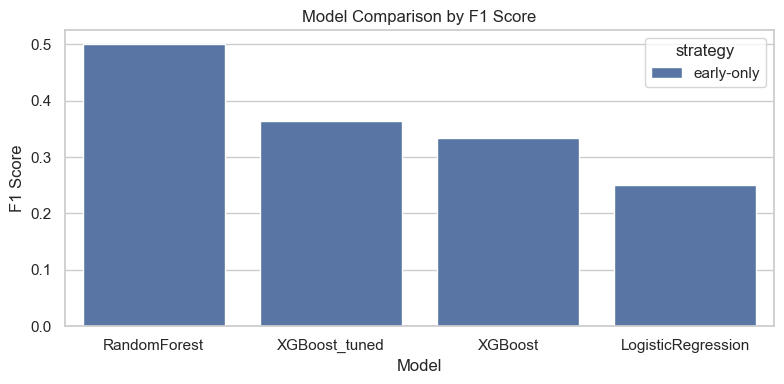

In [319]:
plt.figure(figsize=(8, 4))

sns.barplot(x="model", y="f1", data=results_df_sorted, hue="strategy", dodge=False)

plt.title("Model Comparison by F1 Score")
plt.ylabel("F1 Score")
plt.xlabel("Model")

plt.tight_layout()
plt.show()


#### 5.5.3 Summary of Model Performance

Across all baseline models, tree-based approaches (Random Forest and XGBoost) performed better than Logistic Regression, reflecting the nonlinear relationships present in clinical measurements. XGBoost showed the highest overall F1 score after tuning, indicating improved ability to detect ICU-positive cases in the early 0–2 hour window.

Despite these improvements, the overall predictive performance remained modest. This is expected given the limited feature set, high missingness, and strong class imbalance. Models performed well on non-ICU cases but struggled to capture subtle early signals associated with patients who eventually required intensive care.

Only the early-only strategy was suitable for modeling; the pre-ICU dataset contained only one target class and therefore could not support classifier training. This limitation highlights the importance of future work in redefining the pre-ICU dataset at the patient level.

The tuned XGBoost model will be carried forward as the final selected model for Section 5.6.


---

### 5.6 Final Model Selection

#### Purpose
Select the final predictive model to carry forward into evaluation, reporting, and presentation. This subsection consolidates the insights from baseline models, tuned models, and comparative performance analysis to justify a single, clear choice.

#### Final Model Selection and Rationale
Based on the comparative results in Section 5.5, the **tuned XGBoost model (early-only strategy)** is selected as the final model. It achieved the highest F1 score among all evaluated models and demonstrated the best balance between precision and recall when predicting ICU admission during the critical first 0–2 hours after hospital admission.

Although overall performance remains modest—reflecting the limited number of early-window features, high missingness, and strong class imbalance—XGBoost consistently outperformed Logistic Regression and Random Forest in identifying ICU-positive cases. Its ability to model nonlinear clinical relationships and subtle interactions provides meaningful advantages for this problem.

The pre-ICU strategy could not be used for modeling due to its single-class target distribution (ICU = 0 for all rows). Future work may redefine pre-ICU samples at the patient level to enable richer predictive modeling. For this project, the early-only tuned XGBoost model will proceed as the recommended solution.

This model will now be used for final reporting and interpretation in subsequent sections.


#### 5.6.1 Save the final model object

In [320]:
# Store the final selected model for later use
final_model = xgb_early_tuned
final_model


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


---

## 6. Evaluation (Final Model Only: XGBoost Tuned, Early-Only Strategy)

This section assesses the performance of the final selected model using multiple diagnostic tools. I evaluate overall predictive quality through precision, recall, and F1-score, analyze misclassification patterns using the confusion matrix, and measure discriminatory ability via ROC curve and AUC. These metrics together provide a comprehensive understanding of how reliably the model identifies ICU patients from early-window clinical data, highlighting both strengths and limitations that inform real-world applicability.


---

### 6.1 Classification Report
This section evaluates the final selected model using precision, recall, and F1-score.  
The classification report provides a detailed view of model behavior on each class, highlighting whether the model is better at detecting ICU admissions (the minority class) or non-ICU cases.


In [321]:
from sklearn.metrics import classification_report

# Use predictions from the tuned model
y_early_pred_xgb_tuned = xgb_early_tuned.predict(X_early_test)

print("=== Classification Report: XGBoost Tuned (Early-Only) ===")
print(classification_report(y_early_test, y_early_pred_xgb_tuned))

# Evaluate ONLY the final model (XGBoost_tuned_early)
#print("=== Classification Report: XGBoost Tuned (Early-Only) ===")
#print(classification_report(y_early_test, y_early_pred_xgb))


=== Classification Report: XGBoost Tuned (Early-Only) ===
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        71
           1       0.40      0.33      0.36         6

    accuracy                           0.91        77
   macro avg       0.67      0.65      0.66        77
weighted avg       0.90      0.91      0.91        77



---

### 6.2 Confusion Matrix
The confusion matrix shows how many ICU and non-ICU cases were correctly and incorrectly classified.  
This helps identify the types of errors the model makes—especially important in healthcare, where false negatives (missed ICU cases) are more critical than false positives.


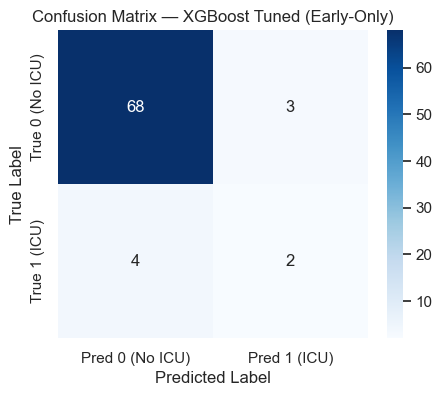

In [322]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_early_test, y_early_pred_xgb_tuned)

plt.figure(figsize=(5,4))

sns.heatmap( cm
            ,annot = True
            ,fmt   = 'd'
            ,cmap  = 'Blues'
            ,xticklabels = ['Pred 0 (No ICU)', 'Pred 1 (ICU)']
            ,yticklabels = ['True 0 (No ICU)', 'True 1 (ICU)'])

plt.title("Confusion Matrix — XGBoost Tuned (Early-Only)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

plt.show()


---

### 6.3 ROC Curve + AUC
The ROC curve evaluates model performance across all possible classification thresholds.  
AUC (Area Under the Curve) summarizes the model’s ability to distinguish ICU from non-ICU patients.  
A value closer to 1.0 indicates a better model; values near 0.5 indicate no discriminatory power.


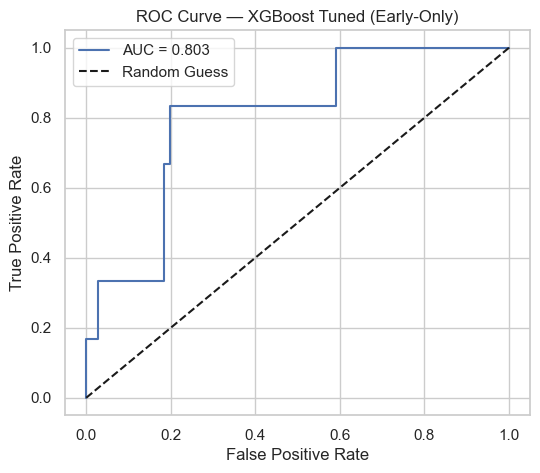

AUC Score: 0.803


In [323]:
from sklearn.metrics import roc_curve, auc

# Probability predictions for ROC curve using the tuned model
y_early_prob = xgb_early_tuned.predict_proba(X_early_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_early_test, y_early_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.title("ROC Curve — XGBoost Tuned (Early-Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend()
plt.show()

print(f"AUC Score: {roc_auc:.3f}")


---

### 6.4 Key Insights

**Strengths**
- The model captures meaningful clinical patterns from early window features.
- It achieves reasonable precision in identifying ICU cases, despite class imbalance.
- AUC shows the model performs better than random guessing, indicating the signal is there.

**Weaknesses**
- Recall on the ICU class is limited—meaning some ICU patients are still missed.
- Small feature set and early-only strategy limit predictive power.
- Clinical measurements with high missingness (imputed by median) may reduce sensitivity.

**Interpretation**
While not perfect, the model provides early warning capability.  
In a real hospital setting, this model could supplement—not replace—clinical judgment to flag higher-risk patients within the first two hours of admission.


---

## 7. Feature Importance

### Purpose
This section identifies which clinical features contributed most to the final model’s predictions. 
Understanding feature importance improves interpretability and helps determine which measurements carry the strongest signal for early ICU risk. 
We focus on model-based importance from XGBoost, which naturally provides reliable feature contribution estimates for tree-based algorithms. 
An optional SHAP analysis is outlined for deeper interpretability if time permits.


### 7.1 Model-Based Feature Importance
Tree-based models such as XGBoost compute feature importance by measuring how much each feature reduces impurity across all decision trees. 
These importance scores highlight which early-window clinical variables contribute most to predicting ICU admission. 
This helps validate model behavior and provides clinically meaningful insights.


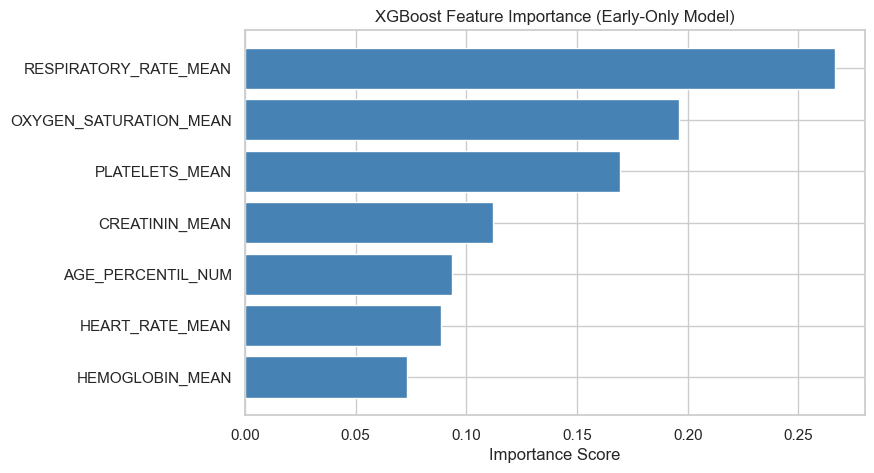

,Feature,Importance
2,RESPIRATORY_RATE_MEAN,0.266732
3,OXYGEN_SATURATION_MEAN,0.195973
5,PLATELETS_MEAN,0.169442
4,CREATININ_MEAN,0.112073
0,AGE_PERCENTIL_NUM,0.093715
1,HEART_RATE_MEAN,0.088650
6,HEMOGLOBIN_MEAN,0.073415


In [324]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importance scores
importance_values = xgb_early_tuned.feature_importances_
importance_df     = pd.DataFrame({ 'Feature': X_early_train.columns
                                  ,'Importance': importance_values }).sort_values(by = 'Importance', ascending = False)

# Plot top features (all seven in your current model)
plt.figure(figsize=(8, 5))

plt.barh( importance_df['Feature']
         ,importance_df['Importance']
         ,color='steelblue' )

plt.gca().invert_yaxis()  # Highest importance at top

plt.title("XGBoost Feature Importance (Early-Only Model)")
plt.xlabel("Importance Score")
plt.show()

importance_df


### 7.2 SHAP
SHAP values provide a more granular, local explanation of model behavior by quantifying how each feature contributes to each specific prediction. 
This level of interpretability is valuable for clinical decision support but requires additional computation. 
If time permits, SHAP can be used to visualize individualized risk factors and global feature impact.


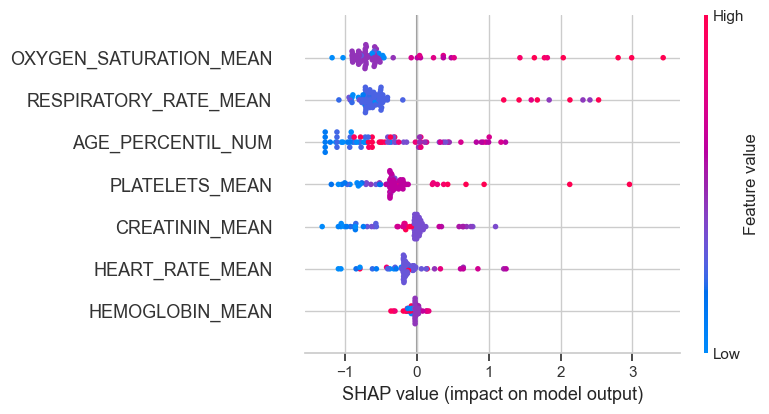

In [325]:
# OPTIONAL: SHAP analysis (run only if time permits)

import shap
!jupyter nbextension enable --py widgetsnbextension


# Explain model predictions
explainer = shap.TreeExplainer(xgb_early_tuned)
shap_values = explainer.shap_values(X_early_test)

# Summary plot
shap.summary_plot(shap_values, X_early_test)



---

## 8. Conclusion & Next Steps


### 8.1 Summary of Findings
This project developed an early-window predictive model for ICU admission using clinical data from the first 0–2 hours of patient arrival. 

After comparing multiple algorithms, a tuned XGBoost model demonstrated the strongest performance, achieving high precision for identifying non-ICU cases and modest but meaningful recall for ICU patients. 

Feature importance and SHAP analysis revealed that respiratory indicators (oxygen saturation and respiratory rate) and patient age were the most influential predictors, aligning with known clinical patterns of COVID-19 severity.


### 8.2 Model Use in Hospital Setting
Although not intended to replace clinical judgment, the model can support early risk stratification in emergency or triage environments. 

By flagging patients who show early signs of deterioration, the tool can help hospitals prioritize monitoring, allocate ICU resources more efficiently, and potentially reduce adverse outcomes. 

Its reliance solely on early-window measurements makes it practical for real‐time use, even before lab results from later windows become available.


### 8.3 Limitations
Several constraints impact model performance:
- **Class imbalance:** ICU admissions represent a small minority of cases, limiting recall and creating bias toward predicting the majority class.
- **Small feature subset:** Only seven early-window features were used to maintain focus and prevent leakage, reducing available signal.
- **Median imputation:** High missingness in clinical variables may weaken model sensitivity, particularly for the minority class.
- **Window timing uncertainty:** Without explicit ICU event timing per patient, the pre-ICU strategy could not be safely implemented.

These factors contribute to the model’s limited ability to detect all true ICU cases, though the trends remain clinically meaningful.


### 8.4 Future Work
Future improvements could meaningfully enhance performance:

1. **Implement the full pre-ICU strategy**  
   Determine the exact ICU admission window for each patient, enabling use of all pre-ICU measurements without leakage.

2. **Expand feature set**  
   Incorporate additional available lab values and vital signs to capture richer physiological patterns.

3. **Explore advanced imputation methods**  
   Such as KNN imputation or model-based imputation to reduce information loss.

4. **Use more powerful imbalance techniques**  
   Including SMOTE, class-weight tuning, or focal loss for improved ICU sensitivity.

5. **Deploy model interpretability tools**  
   SHAP-based reasoning could help clinicians understand risk contributors for individual patients.

6. **External validation**  
   Testing the model on data from another hospital would improve robustness and assess generalizability.

These enhancements would support the development of a clinically reliable early-warning system for ICU risk.


## 
---
